In [38]:

from IPython.display import display
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy import sparse
import joblib

from sklearn.inspection import permutation_importance

plt.rcParams['figure.figsize'] = (9, 5)
plt.rcParams['axes.grid'] = True

RESULTS_DIR = Path('../results')
METRICS_CSV = RESULTS_DIR / 'metrics_comparison.csv'
FEATURE_RF = RESULTS_DIR / 'feature_importance_rf.csv'
FEATURE_NAMES_JSON = RESULTS_DIR / 'feature_names.json'

def load_matrix(path: Path):
    path = Path(path)
    candidates = []
    if path.suffix:
        candidates.append(path)
    candidates.extend([path.with_suffix('.npz'), path.with_suffix('.npy')])
    for p in candidates:
        if not p.exists():
            continue
        try:
            return sparse.load_npz(p)
        except Exception:
            try:
                return np.load(p, allow_pickle=False)
            except Exception:
                pass
    raise FileNotFoundError(f'Could not load matrix for {path} (tried .npz and .npy).')


In [39]:

# Metrics overview
metrics = pd.read_csv(METRICS_CSV)
display(metrics)

required_cols = {'Model', 'Split', 'R2_log', 'MAE_raw', 'RMSE_raw'}
missing = required_cols - set(metrics.columns)
if missing:
    raise ValueError(f'metrics_comparison.csv missing columns: {missing}')


,Model,Split,R2_log,MAE_raw,RMSE_raw
0,RandomForest,valid,0.890540,15065.774933,25088.529262
1,RandomForest,test,0.848380,16211.735337,26865.945959
2,MLPRegressor,valid,0.638973,30924.641901,200291.049978
3,MLPRegressor,test,0.653857,40978.552360,490898.268630
4,RandomForest_TUNED,test,0.874896,15182.957570,24210.308930
5,MLPRegressor_TUNED,test,0.787619,21193.597775,113855.255703


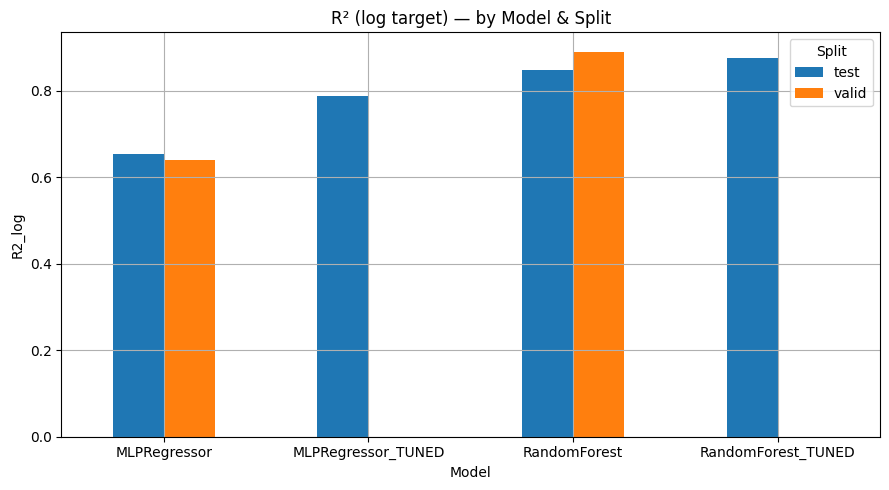

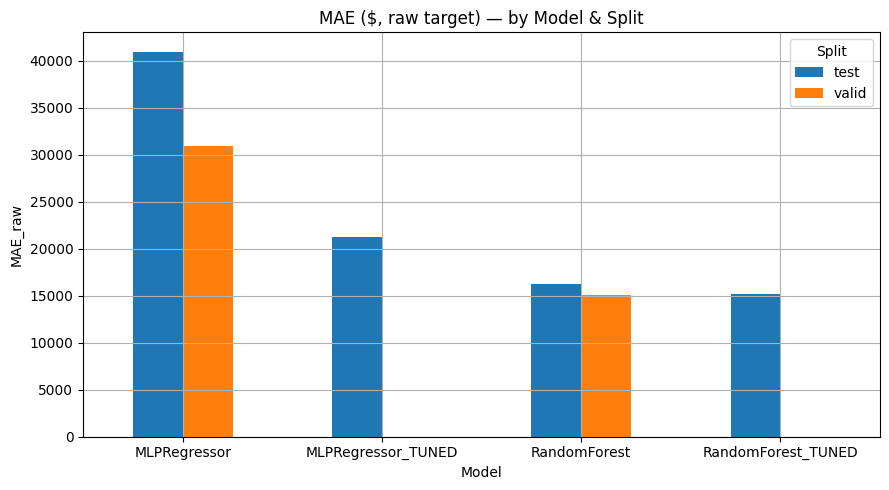

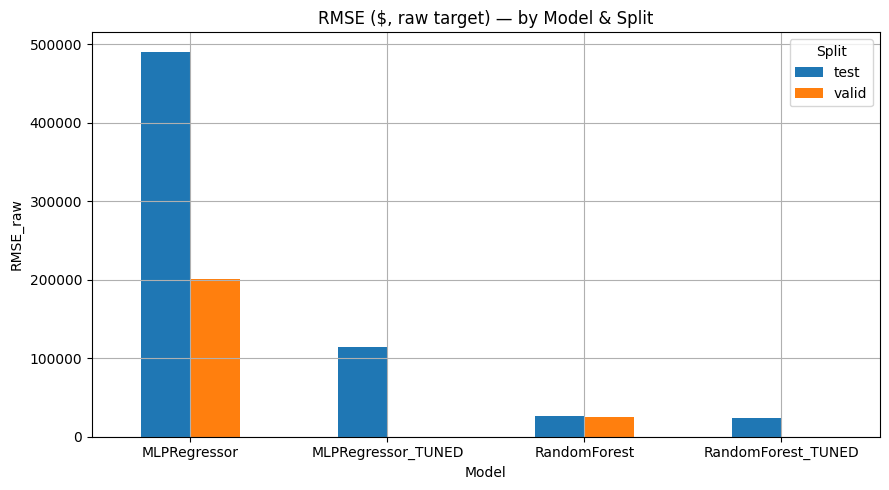

In [40]:

# Bar charts - validation and test metrics
def plot_metric(df: pd.DataFrame, metric: str, title: str):
    pivot = df.pivot(index='Model', columns='Split', values=metric)
    ax = pivot.plot(kind='bar', rot=0, figsize=(9,5), title=title)
    ax.set_xlabel('Model')
    ax.set_ylabel(metric)
    plt.tight_layout()
    plt.show()

plot_metric(metrics, 'R2_log', 'R² (log target) — by Model & Split')
plot_metric(metrics, 'MAE_raw', 'MAE ($, raw target) — by Model & Split')
plot_metric(metrics, 'RMSE_raw', 'RMSE ($, raw target) — by Model & Split')


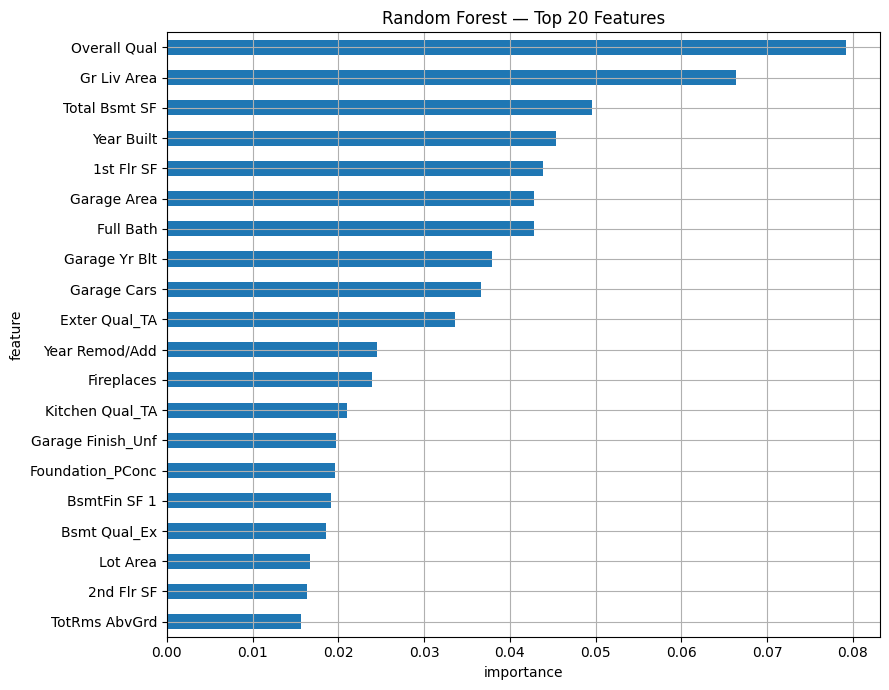

In [41]:

# Feature importances - random forest
if FEATURE_RF.exists():
    imp_rf = pd.read_csv(FEATURE_RF).sort_values('importance', ascending=False)
    top = imp_rf.head(20).iloc[::-1]
    ax = top.plot(kind='barh', x='feature', y='importance', legend=False, figsize=(9,7), title='Random Forest — Top 20 Features')
    ax.set_xlabel('importance')
    ax.set_ylabel('feature')
    plt.tight_layout()
    plt.show()
else:
    print('[skip] feature_importance_rf.csv not found — train RandomForest first.')


Computing permutation importance for model_mlp_tuned.joblib on 440 samples...


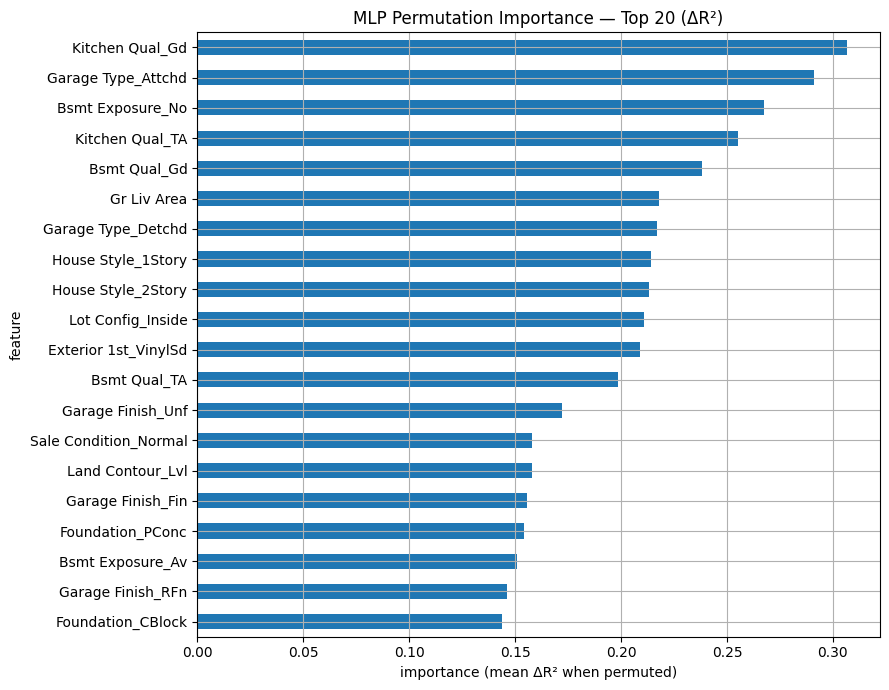

In [42]:

# Permutation importance - MLP regressor
X_test = load_matrix(RESULTS_DIR / 'X_test')
y_test_log = np.load(RESULTS_DIR / 'y_test_log.npy')
y_test_raw = np.load(RESULTS_DIR / 'y_test_raw.npy')

feature_names = []
if FEATURE_NAMES_JSON.exists():
    import json
    feature_names = json.loads(FEATURE_NAMES_JSON.read_text())

mlp_paths = [RESULTS_DIR / 'model_mlp_tuned.joblib', RESULTS_DIR / 'model_mlp.joblib']
mlp_model = None
mlp_name = None
for p in mlp_paths:
    if p.exists():
        mlp_model = joblib.load(p)
        mlp_name = p.name
        break

if mlp_model is None:
    print('[skip] No MLP model found; skipping permutation importance.')
else:
    if sparse.issparse(X_test):
        X_for_mlp = X_test.toarray()
    else:
        X_for_mlp = X_test

    n = X_for_mlp.shape[0]
    idx = np.arange(n)
    if n > 2000:
        rng = np.random.default_rng(42)
        idx = rng.choice(idx, size=2000, replace=False)
        X_for_mlp = X_for_mlp[idx]
        y_for_mlp = y_test_log[idx]
    else:
        y_for_mlp = y_test_log

    print(f'Computing permutation importance for {mlp_name} on {X_for_mlp.shape[0]} samples...')
    result = permutation_importance(
        mlp_model, X_for_mlp, y_for_mlp,
        scoring='r2', n_repeats=5, random_state=42, n_jobs=-1
    )
    importances = pd.DataFrame({
        'feature': feature_names[:len(result.importances_mean)] if feature_names else np.arange(len(result.importances_mean)),
        'importance': result.importances_mean
    }).sort_values('importance', ascending=False)

    top_mlp = importances.head(20).iloc[::-1]
    ax = top_mlp.plot(kind='barh', x='feature', y='importance', legend=False, figsize=(9,7), title='MLP Permutation Importance — Top 20 (ΔR²)')
    ax.set_xlabel('importance (mean ΔR² when permuted)')
    ax.set_ylabel('feature')
    plt.tight_layout()
    plt.show()


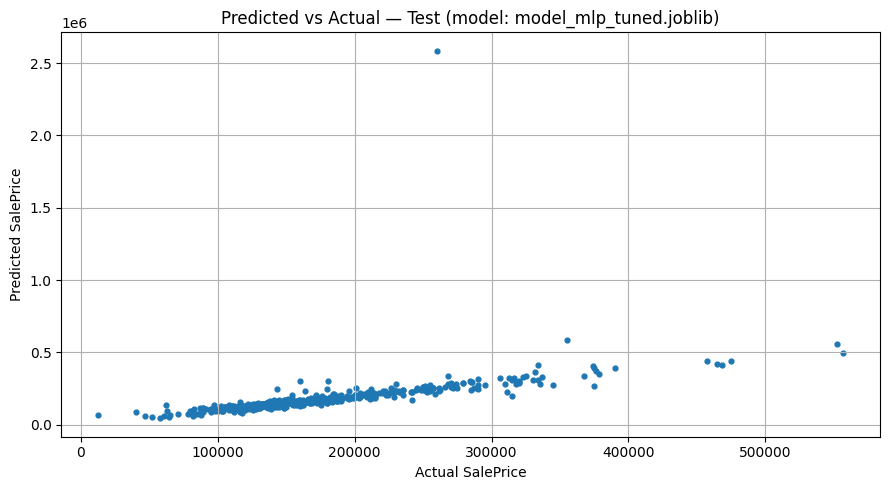

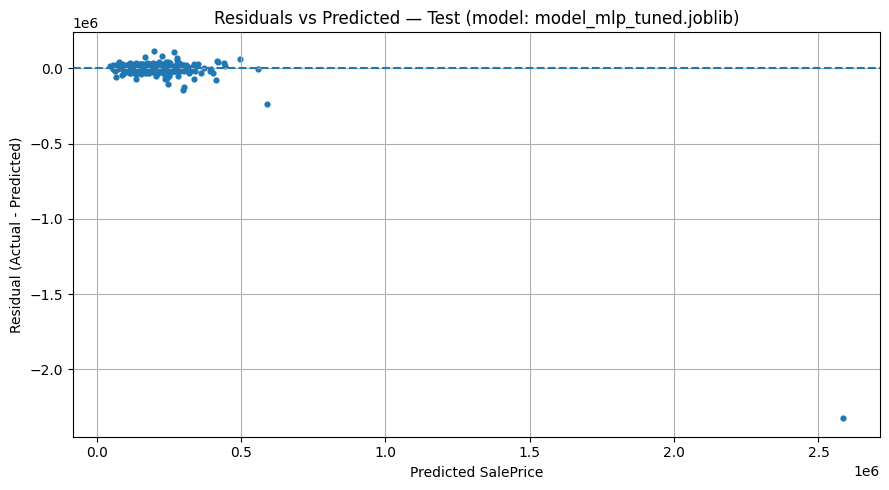

,Residuals Summary
count,4.400000e+02
mean,-5.774298e+03
std,1.138382e+05
min,-2.325974e+06
25%,-1.063685e+04
50%,-3.669643e+02
75%,1.081855e+04
max,1.176665e+05


In [43]:

# Residual analysis on test set
model_paths_ordered = [
    RESULTS_DIR / 'model_mlp_tuned.joblib',
    RESULTS_DIR / 'model_mlp.joblib',
    RESULTS_DIR / 'model_rf_tuned.joblib',
    RESULTS_DIR / 'model_rf.joblib',
]

model = None
chosen = None
for p in model_paths_ordered:
    if p.exists():
        model = joblib.load(p)
        chosen = p.name
        break

if model is None:
    raise FileNotFoundError('No trained model found. Run train_models.py first.')

def to_dense(X):
    if sparse.issparse(X):
        return X.toarray()
    return X

y_pred_log = model.predict(to_dense(X_test))
y_pred_raw = np.expm1(y_pred_log)

plt.figure()
plt.scatter(y_test_raw, y_pred_raw, s=12)
plt.xlabel('Actual SalePrice')
plt.ylabel('Predicted SalePrice')
plt.title(f'Predicted vs Actual — Test (model: {chosen})')
plt.tight_layout()
plt.show()

residuals = y_test_raw - y_pred_raw
plt.figure()
plt.scatter(y_pred_raw, residuals, s=12)
plt.axhline(0, linestyle='--')
plt.xlabel('Predicted SalePrice')
plt.ylabel('Residual (Actual - Predicted)')
plt.title(f'Residuals vs Predicted — Test (model: {chosen})')
plt.tight_layout()
plt.show()

pd.Series(residuals).describe().to_frame('Residuals Summary')
